# PySOM
Inspired by these websites and projects

http://www.ai-junkie.com/ann/som/som1.html

https://github.com/davidasboth/blog-notebooks/blob/master/self-organising-map/Self-Organising%20Map.ipynb

https://bib.irb.hr/datoteka/877545.Brief_Review_of_Self-Organizing_Maps.pdf

http://ifs.tuwien.ac.at/~taha/pub-inf_5021.pdf

http://www.ifs.tuwien.ac.at/dm/somtoolbox/visualisations.html

https://peterwittek.com/somoclu-in-python.html

https://peterwittek.github.io/somoclu/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

## 0. Load test datasets

### 0.1 Fisher's iris dataset

In [2]:
iris = datasets.load_iris()
iris_labels = iris.target_names[iris.target]
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names, index=iris_labels).rename_axis('label').reset_index()
iris_df.head()

,label,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,setosa,5.1,3.5,1.4,0.2
1,setosa,4.9,3.0,1.4,0.2
2,setosa,4.7,3.2,1.3,0.2
3,setosa,4.6,3.1,1.5,0.2
4,setosa,5.0,3.6,1.4,0.2


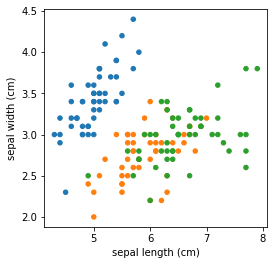

In [3]:
iris_colours = dict(zip(iris.target_names, [f'C{i}' for i in range(len(iris.target_names))]))
iris_df.plot.scatter(x='sepal length (cm)', y='sepal width (cm)', color=iris_df['label'].map(iris_colours), figsize=(4,4));

Test-train split of iris:

In [4]:
X1_train, X1_test, y1_train, y1_test = train_test_split(iris['data'], iris.target, test_size=0.5, shuffle=True)

### 0.2 MNIST handwritten digits dataset

MNIST 8x8 handwritten digits dataset built into Scikit-Learn.

https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

In [5]:
digits = datasets.load_digits()
digits_labels = digits.target_names[digits.target]
digits_df = pd.DataFrame(digits.data, columns=digits.feature_names, index=digits_labels).rename_axis('label').reset_index()
digits_df.head()

,label,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


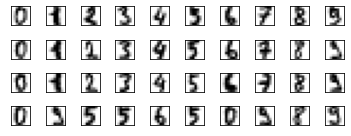

In [6]:
fig = plt.figure(figsize=(5,2))
for i in range(40):
    ax = plt.subplot2grid((4,10), (i//10, i%10))
    ax.imshow(digits['data'][i].reshape((8,8)), cmap='gray_r')
    ax.set_xticklabels([]); ax.set_yticklabels([]);
    ax.set_xticks([]); ax.set_yticks([]);
    plt.grid(False)
plt.tight_layout();

Test-train split of digits:

In [7]:
X2_train, X2_test, y2_train, y2_test = train_test_split(digits['data'], digits.target, test_size=0.5, shuffle=False)

## 1. Simple SOM code

Define a simple class for training Self-Organising Maps.

In [8]:
class SOM(object):
    """Self-Organising Map (SOM) training and analysis on a rectangular grid.

    Attributes
    ----------
    n_rows : int
        Number of rows of neurons.
    n_cols : int
        Number of columns of neurons.
    neighbourhood : str, optional
        Form of neighbourhood function on SOM. `gaussian` by default,
        with options `exponential`, `linear`, `gaussian`.
    bmus : ndarray
        1D array of Best Matching Units (BMUs) for each training instance.
    wts: ndarray
        SOM weights (codebook). Rows correspond to neurons, columns to
        weights in feature space.
    """
    
    
    def __init__(self, n_rows, n_cols, neighbourhood='gaussian'):
        """Class constructor.
        
        Parameters
        ----------
        n_rows : int
            Number of rows in SOM.
        n_cols : int
            Number of columns in SOM.
        neighbourhood : str, optional
            Form of neighbourhood function on SOM. Options available:
            `gaussian` (default), `exponential`, `linear`, `bubble`.
        """
        
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.neighbourhood = neighbourhood
        self.bmus = None
        self.wts = None
        
        # Calculate distance**2 matrix for neuron array
        ixs = np.arange(n_rows*n_cols)       
        rows, cols = ixs % n_cols, ixs // n_cols
        self.d2mat = (rows[:,None] - rows[None,:])**2 + (cols[:,None] - cols[None,:])**2

    
    def calc_BMUs(self, X):
        """Calculate Best-Matching Units (BMUs) for training data array X.
        
        Parameters
        ----------
            X : ndarray
                Training data, with rows as instances, columns as features.
        """

        return ((X[:,None] - self.wts)**2).sum(axis=2).argmin(axis=1)

    
    def make_kernels(self):
        """Generate kernels for all epochs. 
        
        User-defined kernel weights at the maximum radius Rmax for the
        first epoch, and unit radius R1 at the final epoch.
        """ 
        
        # Define kernels based on neighbourhood function
        if self.neighbourhood == 'bubble':
            sigs = np.linspace(self.Rmax, 0.5, self.n_epochs)
            self.kernels = np.where(np.sqrt(self.d2mat)[None,:,:]<=sigs[:,None,None], 1, 0)
        elif self.neighbourhood == 'linear':
            sig_Rmax = (1 - self.h0_Rmax)/self.Rmax
            sig_R1 = (1 - self.hN_R1)
            sigs = np.linspace(sig_Rmax, sig_R1, self.n_epochs)
            self.kernels = np.clip(1 - np.sqrt(self.d2mat[None,:,:])*sigs[:,None,None], 0, 1)
        elif self.neighbourhood == 'exponential':
            sig_Rmax = -self.Rmax/np.log(self.h0_Rmax)
            sig_R1 = -1/np.log(self.hN_R1)
            sigs = np.linspace(sig_Rmax, sig_R1, self.n_epochs)
            self.kernels = np.exp(-np.sqrt(self.d2mat[None,:,:])/sigs[:,None,None])
        elif self.neighbourhood == 'gaussian':
            sig_Rmax = np.sqrt(-self.Rmax**2/np.log(self.h0_Rmax))
            sig_R1 = np.sqrt(-1/np.log(self.hN_R1))
            sigs = np.linspace(sig_Rmax, sig_R1, self.n_epochs)
            self.kernels = np.exp(-self.d2mat[None,:,:]/sigs[:,None,None])
        else:
            print('Invalid neighbourhood')
            return None

    
    def fit(self, X, labels=None, n_epochs=10, h0_Rmax=0.5, hN_R1=0.01, Rmax=None, 
            initial='random'):
        """Train SOM on input data array X using the batch algorithm.
        
        Input array X should be in the standard format, i.e.
        rows (axis 0) are instances, columns (axis 1) are features.

        Parameters
        ----------
            X : ndarray
                Training data, with rows as instances, columns as features.
            labels : ndarray or list
                Labels of training data for supervised training.
            n_epochs : int, optional
                Number of training epochs.
            h0_Rmax : float, optional
                Initial kernel weight at Rmax.
            hN_R1 : float, optional
                Final kernel weight at unit radius (distance to nearest neighbours).
            Rmax : float, optional
                Maximum radius of neighbourhood kernel.
            initial : str, optional
                Weights initialisation method. One of `random` or `pca`.
        """
        
        self.n_epochs = n_epochs
        self.h0_Rmax = h0_Rmax
        self.hN_R1 = hN_R1
        self.Rmax = Rmax
        
        # Set initial neighbourhood radius to be the largest distance in the SOM
        if Rmax is None:
            self.Rmax = np.sqrt((self.n_cols-1)**2 + (self.n_rows-1)**2)
        else:
            self.Rmax = Rmax
        
        # Initialise SOM weights as a random array or using PCA
        n_samp, n_feat = X.shape
        if initial == 'random':
            self.wts = np.random.random(size=(self.n_rows*self.n_cols, n_feat))
        elif initial == 'pca':
            X_mean = X.mean(axis=0)
            X_zm = X - X_mean
            covmat = (X_zm.T @ X_zm)/n_samp
            eigvals, eigvecs = np.linalg.eigh(covmat)

            # Variance explained by PCs beyond the first two
            resid_variance = eigvals[:-2].sum()
            
            # Generate Gaussian noise to make up variance
            noise = np.random.normal(loc=0, scale=np.sqrt(resid_variance), size=(self.n_rows, self.n_cols, n_feat))
            
            # Ranges of row PCs (for EOF1) and column PCs (for EOF2) over SOM
            row_facs = np.linspace(-eigvals[-1], eigvals[-1], self.n_rows)
            col_facs = np.linspace(-eigvals[-2], eigvals[-2], self.n_cols)
            col_facs, row_facs = np.meshgrid(col_facs, row_facs)
            
            self.wts = ((row_facs[:,:,None] * eigvecs[:,-1]) + 
                        (col_facs[:,:,None] * eigvecs[:,-2]) + 
                        noise + X_mean
                       ).reshape((n_rows*n_cols, -1))
        else:
            print('initial must be random or pca')
            return None

        # Define kernels based on neighbourhood function
        self.make_kernels()

        for i in range(n_epochs):
            # Calculate BMUs for all training vectors
            bmus = self.calc_BMUs(X)
            
            # Calculate numerator (BMU kernel-weighted sum of training data)
            num = (X[:,None] * self.kernels[i][bmus][:,:,None]).sum(axis=0)
            
            # Calculate denominator (sum of BMU weights for training data) and update weights
            denom = self.kernels[i][bmus].sum(axis=0)
            self.wts = num/denom[:,None]
            
        # Update BMUs
        self.bmus = self.calc_BMUs(X)
        
        # Calculate distance matrix of neurons in feature space
        self.dmat = np.sqrt(((self.wts[:,None] - self.wts)**2).sum(axis=2))
        
        # Supervised learning, if labels supplied
        labelmap = np.empty(self.n_cols*self.n_rows)
        labelmap[:] = np.nan
        
        if labels is not None:
            labels = np.array(labels)
            
            # Define mapping from neurons to classes using majority vote
            for i in range(self.n_cols*self.n_rows):
                labels_i = labels[self.bmus==i]
                values, counts = np.unique(labels_i, return_counts=True)
                if counts.size > 0:
                    labelmap[i] = values[np.argmax(counts)]
            
            # If any values in labelmap are nan, backfill with the closest non-nan neuron
            # Fill all nan neurons columns in feature distance matrix with large number
            dmat_nonan = np.where(np.isnan(labelmap), 1e9, self.dmat)
            
            # Get column indices of nearest neurons for all rows
            nearest_nonan = dmat_nonan.argsort(axis=1)[:,0]
            
            # Backfill nan values
            labelmap = np.where(np.isnan(labelmap), labelmap[nearest_nonan], labelmap)

        self.labelmap = labelmap


    def predict(self, X):
        """Predict classes of data.
        
        Makes use of supervised classification if labelled 
        training data are available.
        
        Parameters
        ----------
            X : ndarray
                Training data, with rows as instances, columns as features.
                
        Returns
        -------
            predicted : ndarray
                Predicted labels.
        """
        
        if self.wts is None:
            print('Train SOM before classifying')
            return None
        
        bmus = self.calc_BMUs(X)
        
        if self.labelmap is None:
            return bmus
        else:
            return np.array([self.labelmap[bmu] for bmu in bmus])


    def umatrix(self, figsize=(6,6)):
        """Plot U-matrix."""
   
        # Create empty U-matrix of appropriate dimensions
        umat = np.zeros((self.n_rows*2-1, self.n_cols*2-1))
        
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        # Loop over neurons
        for i in range(self.n_rows * self.n_cols):
            row, col = i // self.n_cols, i % self.n_cols
            
            # Calculate means of distances in feature space to immediate neighbours
            dmat_neighbours = np.where((self.d2mat>0) & (self.d2mat<=2), self.dmat, np.nan
                                      )[i].reshape((self.n_rows, self.n_cols))
            dmat_neighbours_mean = np.nanmean(dmat_neighbours)
            umat[row*2, col*2] = dmat_neighbours_mean
            
            # Plot each neuron
            ax.plot([col*2], [row*2], marker='o', color='k', markersize=2)

            # Subset row, column coordinates of neighbours and calculate offset
            rows_alt, cols_alt = np.where(~np.isnan(dmat_neighbours))
            rows_offset, cols_offset = rows_alt - row, cols_alt - col
            
            # Fill between-neuron distances in U-matrix
            umat[row*2+rows_offset, col*2+cols_offset] = dmat_neighbours[rows_alt, cols_alt]
        
        # Save and plot U-matrix
        self.umat = umat
        ax.imshow(umat, cmap='Reds')
        ax.tick_params(labelbottom=False,labeltop=True)
        plt.tight_layout()
        
        
    def component_planes(self, i=None, cmap='viridis_r', figsize=(6,6)):
        """Plot component planes.
        
        Parameters
        ----------
            i : int, list or ndarray
                Index or indices of neuron weights to visualise.
            cmap : str
                Matplotlib colourmap.
        """
        
        if i is None:
            to_loop = range(self.wts.shape[1])
        elif isinstance(i, int):
            to_loop = [i]
        else:
            to_loop = i
            
        # Loop over dimensions of codebook
        for i in to_loop:
            arr = self.wts[:,i].reshape((self.n_rows, self.n_cols))
            fig, ax = plt.subplots(1, 1, figsize=figsize)
            ax.imshow(arr, cmap=cmap)

## 2. Test on datasets

### 2.1 Fisher's iris dataset

In [9]:
n_rows, n_cols, n_epochs = 30, 30, 20
som1 = SOM(n_rows, n_cols, neighbourhood='gaussian')

som1.fit(X1_train, labels=y1_train, n_epochs=n_epochs, initial='random')
predicted1 = som1.predict(X1_test)
print(classification_report(y1_test, predicted1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.85      0.96      0.90        23
           2       0.96      0.85      0.90        27

    accuracy                           0.93        75
   macro avg       0.93      0.94      0.93        75
weighted avg       0.94      0.93      0.93        75



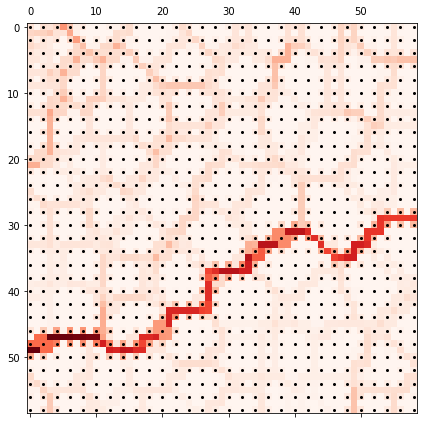

In [10]:
som1.umatrix()

### 2.2 MNIST handwritten digits dataset

In [11]:
n_rows, n_cols, n_epochs = 20, 20, 20
som2 = SOM(n_rows, n_cols, neighbourhood='linear')

som2.fit(X2_train, labels=y2_train, n_epochs=n_epochs, initial='pca')
predicted2 = som2.predict(X2_test)
print(classification_report(y2_test, predicted2))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        88
           1       0.94      0.97      0.95        91
           2       0.98      0.98      0.98        86
           3       0.94      0.90      0.92        91
           4       0.97      0.90      0.93        92
           5       0.92      0.96      0.94        91
           6       0.99      1.00      0.99        91
           7       0.99      0.98      0.98        89
           8       0.89      0.88      0.88        88
           9       0.84      0.87      0.86        92

    accuracy                           0.94       899
   macro avg       0.94      0.94      0.94       899
weighted avg       0.94      0.94      0.94       899



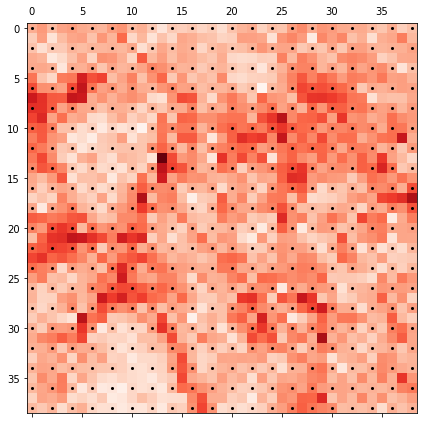

In [12]:
som2.umatrix()

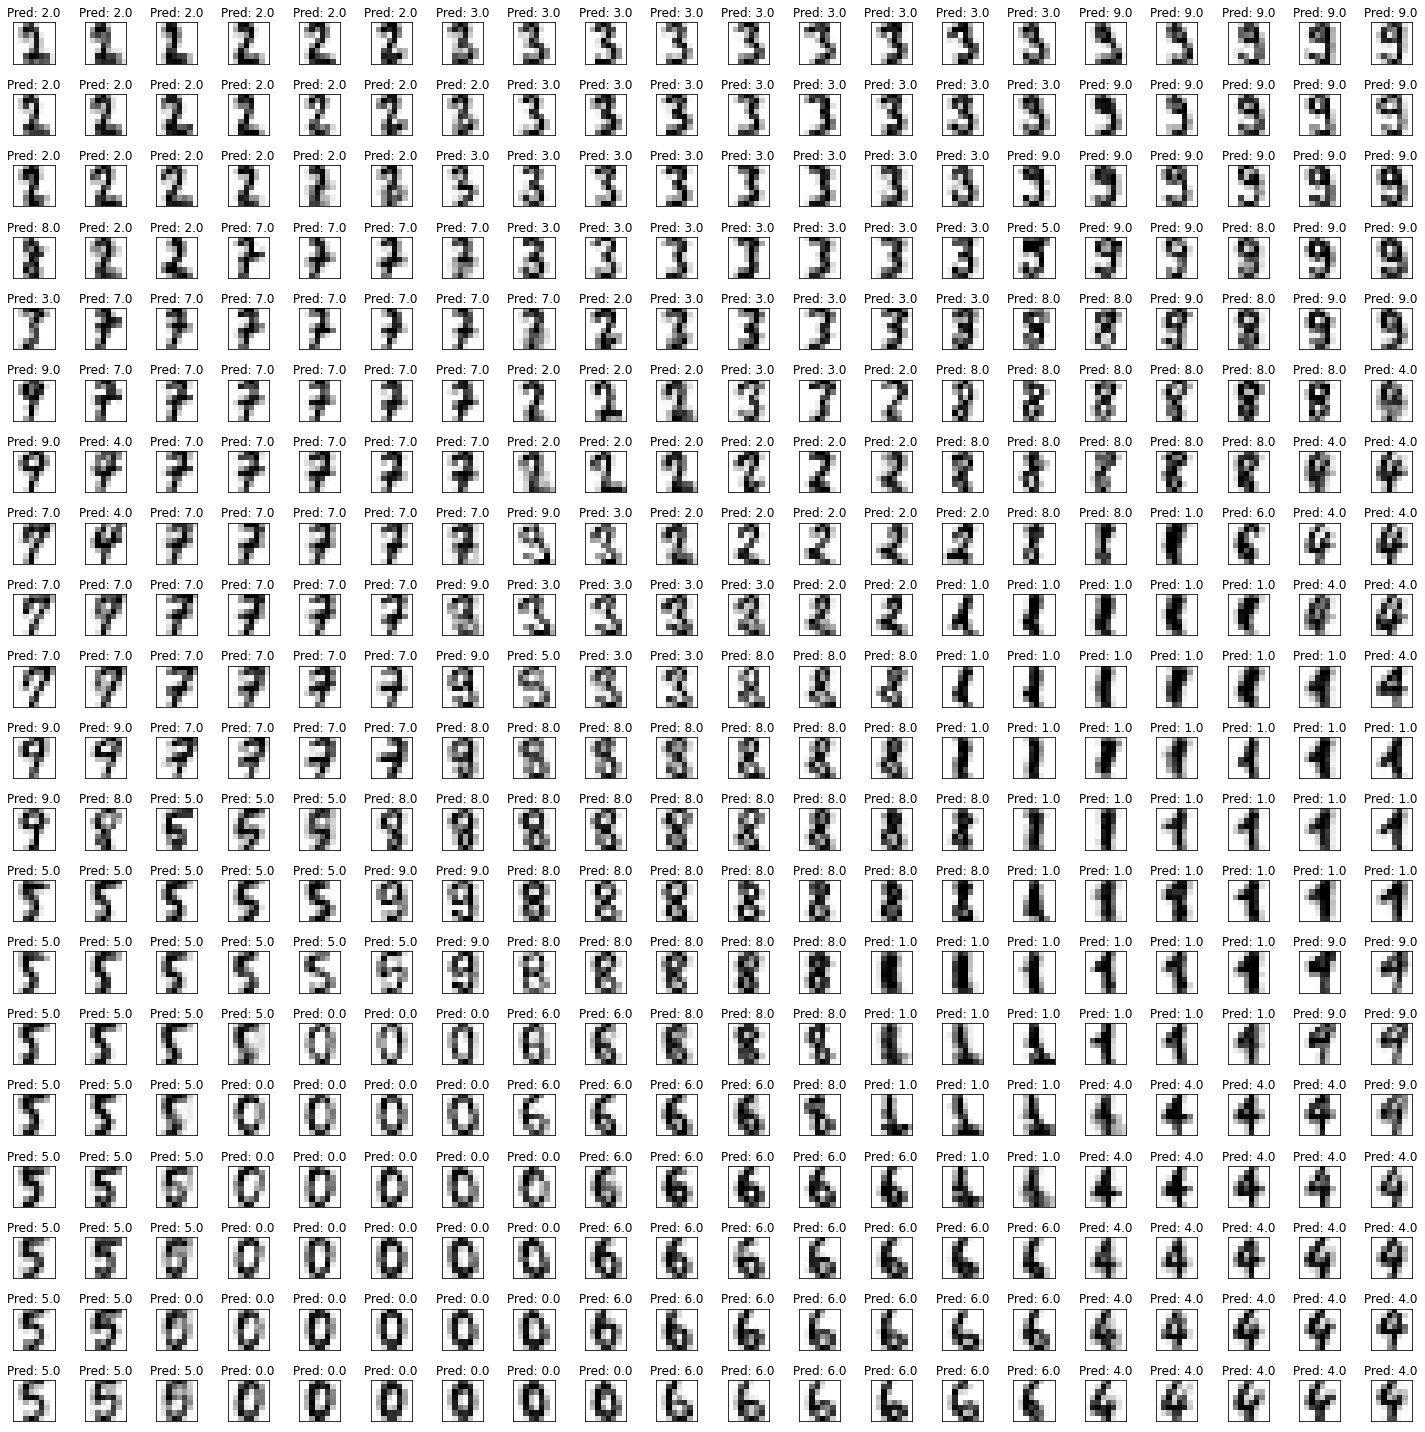

In [13]:
fig, axes = plt.subplots(som2.n_rows, som2.n_cols, figsize=(1*n_cols,1*n_rows))
for k in range(som2.n_cols*som2.n_rows):
    i, j = k//som2.n_cols, k%som2.n_cols
    ax = axes[i][j]
    ax.imshow(som2.wts[k].reshape((8,8)), cmap='gray_r')
    ax.set_xticklabels([]); ax.set_yticklabels([]);
    ax.set_xticks([]); ax.set_yticks([]);
    ax.set_title(f'Pred: {som2.labelmap[k]}')
    plt.grid(False)
plt.tight_layout();